In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import skimage.segmentation as seg
import skimage.filters as filt
import skimage.morphology as morph
import skimage.draw as draw
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import cumtrapz
import scipy.ndimage.filters as filters

In [11]:
def show(img_path):
  plt.imshow(img_path)
  plt.axis('off')
  plt.show()

  
def count_pos(arr):
  count = 0
  for num in arr:
    if num > 0:
        count += 1

  print("Number of positive elements in the array:", count)


In [26]:
def curvature(x, y, xc, yc, r):
    # Shift coordinates to make the center of the circle the origin
    x_shifted = x - xc
    y_shifted = y - yc
    # Calculate distance from each point to the center of the circle
    d = np.sqrt(x_shifted**2 + y_shifted**2)
    # Calculate the curvature only for points inside the circle
    inside_circle = d <= r
    dx_dt = np.gradient(x[inside_circle])
    dy_dt = np.gradient(y[inside_circle])
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = (dx_dt * d2y_dt2 - d2x_dt2 * dy_dt) / (dx_dt**2 + dy_dt**2)**(3/2)
    # Pad the curvature array with zeros for the points outside the circle
    curvature_padded = np.zeros_like(d)
    curvature_padded[inside_circle] = curvature
    return curvature_padded


def integral_curvature(x, y, xc, yc, r):
    k = curvature(x, y, xc, yc, r)
    return cumtrapz(k, initial=0)


def get_integral_curvature(i,x,y, r):
    # Calculate the integral curvature for a circle centered at (x[i], y[i]) with radius r
    int_curv = integral_curvature(x, y, x[i], y[i], r)[-1]
    return int_curv


def get_area_measure(contour,i,radius, thresh):
    # Approximate the contour with a circle centered at the current point
    circle_mask = np.zeros_like(gray)
    cv2.circle(circle_mask, (contour[i][0][0], contour[i][0][1]), radius, (255, 255, 255), -1)
    intersection_mask = cv2.bitwise_and(circle_mask, thresh)
    intersection_area = np.sum(intersection_mask) / 255
    circle_area = np.pi * radius ** 2
    intersection_fraction = intersection_area / circle_area
    # Compute the curvature value for the current point
    return intersection_fraction


def get_curvature_arc_length(contour,i,x,y,radius,circle_perimeters):
    curvature_arr = []
    # Approximate the contour with a circle centered at the current point
    (cx, cy) = x[i], y[i]
    # Calculate the length of the part of the circle's circumference that is inside the object
    chord_length = 2 * np.sqrt(radius**2 - ((radius**2-(x[i]-cx)**2-(y[i]-cy)**2))/4)
    arc_length = 2 * np.arcsin(chord_length / (2 * radius))
    circle_perimeters.append(arc_length)
    if len(circle_perimeters) > 0:
        # Calculate the average perimeter of the fitted circles
        circle_perimeter = np.mean(circle_perimeters)
    else:
        # Use the radius as an estimate for the perimeter
        circle_perimeter = 2 * np.pi * radius

    # Calculate perimeter of the contour
    contour_perimeter = cv2.arcLength(contour, True)
    # Calculate the fraction of the circle's perimeter contained inside the object
    fraction = circle_perimeter / contour_perimeter
    arc_len = fraction * arc_length
    return arc_len


def get_curvatures(contours, radius_arr,thresh):
    curvature_arr=[]
    # Loop over each contour
    for contour in contours:
        curr = []
        # Precompute the coordinates of all points in the contour
        x, y = contour[:, 0, 0], contour[:, 0, 1]
        # Compute the maximum and minimum x and y coordinates of the contour
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        # Compute the thresholded image for the current contour
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)
        thresh = cv2.bitwise_and(gray, mask)
        # Compute the area measure for each point in the contour
        for radius in radius_arr:
            circle_perimeters = []
            arc_length = 0  # Initialize arc_length to 0
            curr = []
            for i in range(len(contour)):
                curr_area = get_area_measure(contour,i,radius,thresh)
                # curr_arc = get_curvature_arc_length(contour,i,x,y,radius,circle_perimeters)
                # curr_int = get_integral_curvature(i,x,y, radius)
                curr.append(curr_area) # remove
                #curr.append(curr_arc)
                #curr.append(curr_int) # add
            curvature_arr.append(curr)

    return curvature_arr
            #print( f'area={curr_area} arc ={curr_arc} curr int = {curr_int}')

In [39]:
# # Convert RGB to HSV and extract the saturation channel
# s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
# # Threshold the saturation image
# s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')


# specify path to the folder containing image files
path = "../../leafsnap/leafsnap-dataset/dataset/segmented/field/"

counter = 0

# initialize empty lists for features and labels
features = []
labels = []

# loop through all subfolders in the path
for foldername in os.listdir(path):
    if counter == 1:
        break
    
    folderpath = os.path.join(path, foldername)
    if not os.path.isdir(folderpath):
        continue
        
    # loop through all image files in the subfolder
    for filename in os.listdir(folderpath):
        filepath = os.path.join(folderpath, filename)
        if not os.path.isfile(filepath):
            continue
        
        # try:
        # load the image file and extract features
        ini_img = cv2.imread(filepath)

        # resize the image
        img = cv2.resize(ini_img, (250, 250))

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # test = pcv.threshold.binary(gray_img=gray, threshold=85, max_value=255, object_type='dark')
        # Threshold the image to get a binary image
        ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        # Find the contours in the image
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        radius_arr = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]
        icurvature_arr = get_curvatures(contours, radius_arr, thresh)
        curvature_arr = np.array(icurvature_arr)
        print(icurvature_arr)
        x = np.arange(curvature_arr.shape[1]) # x-axis is the number of contour points
        y = np.arange(curvature_arr.shape[0]) # y-axis is the different scales
        X, Y = np.meshgrid(x, y)
        hist_values = []
        for i in range(curvature_arr.shape[0]):
            counts, bin_edges = np.histogram(curvature_arr[i], bins=30) # adjust the number of bins as needed
            hist_values.append(counts)
        data = np.array([np.array(hist) for hist in hist_values])
        X = data.flatten().tolist()
        
        features.append(X)
        labels.append(foldername)
        # except:
        #     pass
            
    print(f"Finished plant: {foldername}")
    counter += 1


# convert features and labels to numpy arrays
features = features
labels = np.array(labels)

# save features and labels to a pandas dataframe and export to CSV file
data = pd.DataFrame({"hist_values" : features})
data["plant"] = labels
data.to_csv("leafsnap_data_temp.csv", index=False)

[[0.47022483970758405, 0.49603914734005783, 0.4706991838517011, 0.49298087588456646, 0.47910006829882623, 0.49822362695112304, 0.4792748266677115, 0.4983734198387389, 0.47722765720362753, 0.4950405280892851, 0.47842600030455473, 0.49847328176381617, 0.48363130314920727, 0.5056633403693794, 0.48384350973999646, 0.5038783084586234, 0.47926234392707684, 0.49764942088192876, 0.4734578695319607, 0.48755088370849, 0.43195275692172125, 0.4287696580598833, 0.3525625264852935, 0.3302808344524281, 0.3031558390533153, 0.27921394251604037, 0.22617477755937662, 0.17747960634357396, 0.17429650748173606, 0.19505530515717306, 0.2957660565975975, 0.31181886105376827, 0.4498654897324562, 0.474905867445581, 0.47557993543985255, 0.4971501112565424, 0.473407938569422, 0.4956521823803834, 0.48008620480896425, 0.4991847979799917, 0.4844426812904601, 0.49814873050731506, 0.4847048188437879, 0.5013068638878837, 0.48180882301654715, 0.4981362477666804, 0.4792748266677115, 0.4983734198387389, 0.4852665421723475,

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_24492\1330809587.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  curvature_arr = np.array(icurvature_arr)


IndexError: tuple index out of range

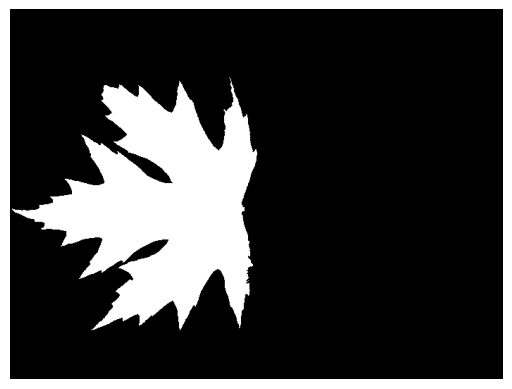

In [27]:
# Load the image
img = cv2.imread("../../leafsnap/leafsnap-dataset/dataset/segmented/field/acer_saccharinum/13001158000696.png")
show(img)
# set the new size
new_size = (250, 250)
# resize the image
img = cv2.resize(img, new_size)
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Threshold the image to get a binary image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# Find the contours in the image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
radius_arr = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]
ini_curvature_arr = get_curvatures(contours,radius_arr, thresh)


In [29]:
print(ini_curvature_arr)

[[0.09861365101380182, 0.13523801203588973, 0.15332550321550983, 0.38516744502302136, 0.4448848762192274, 0.6910570042753269, 0.7422362408774266, 0.7749035731183277, 0.8226001250833578, 0.7809826678074063, 0.7777995689455685, 0.6982220973996208, 0.6536587133338901, 0.5164484282777244, 0.4655188464883179, 0.422316081151765, 0.3713864993623584, 0.2844317281013276, 0.6071230562478833, 0.6962498243793448, 0.7283179850697824, 0.3999220444531877, 0.34295081619660645, 0.34106592236077304, 0.45118866023973, 0.49520280371753567, 0.4347239253426154, 0.4060760355860743, 0.34241405834931615, 0.3201323663164508, 0.2596534879415306, 0.29466757542174754, 0.2996731544162456, 0.3665182305148416, 0.3569689339293279, 0.38036158987867785, 0.34917970377330104, 0.41537567735889486, 0.4432246717148179, 0.5998830666797815, 0.5785625456757848, 0.6193811075511181, 0.5713475215889523, 0.3994601830497053, 0.3716486369156862, 0.42257821870509277, 0.4766908993563372, 0.5053387891128783, 0.47701545061283823, 0.73025

In [37]:
print(len(ini_curvature_arr[0]))

507


[[0.09861365 0.13523801 0.1533255  ... 0.18437008 0.15890529 0.13523801]
 [0.11671987 0.1574885  0.194013   ... 0.1876468  0.16616088 0.1574885 ]
 [0.20380848 0.23570188 0.25794751 ... 0.26333174 0.24635521 0.23570188]
 ...
 [0.06309509 0.06309509 0.06309509 ... 0.06309509 0.06309509 0.06309509]
 [0.0579467  0.0579467  0.0579467  ... 0.0579467  0.0579467  0.0579467 ]
 [0.05340368 0.05340368 0.05340368 ... 0.05340368 0.05340368 0.05340368]]


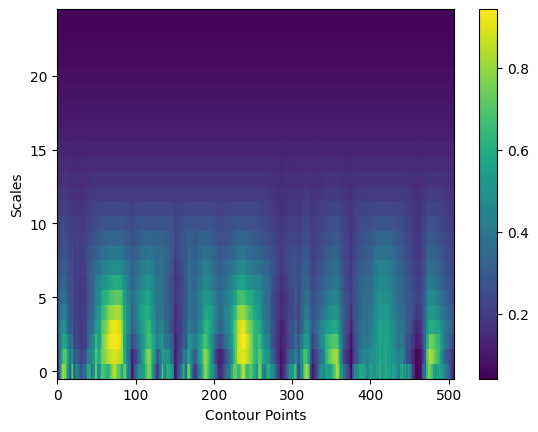

In [32]:
curvature_arr = np.array(ini_curvature_arr)
print(curvature_arr)
x = np.arange(curvature_arr.shape[1]) # x-axis is the number of contour points
y = np.arange(curvature_arr.shape[0]) # y-axis is the different scales
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, curvature_arr)
plt.colorbar()
plt.xlabel('Contour Points')
plt.ylabel('Scales')
plt.show()

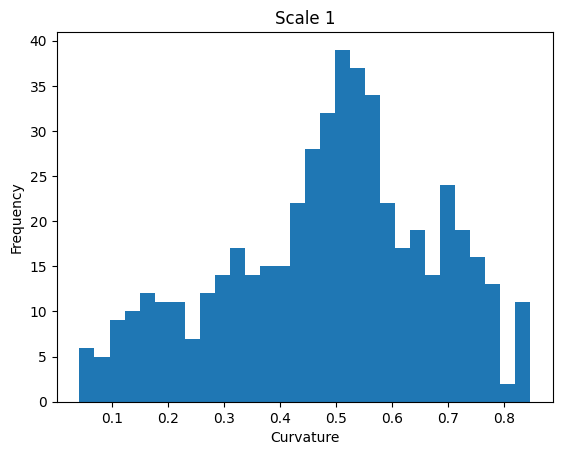

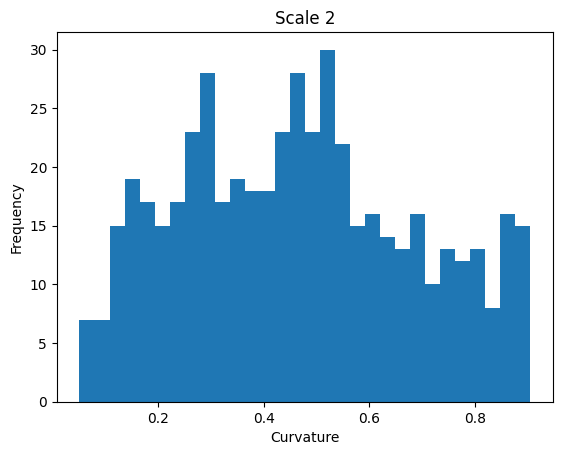

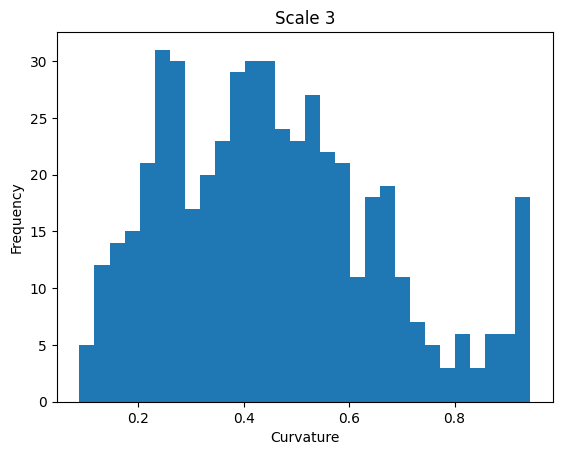

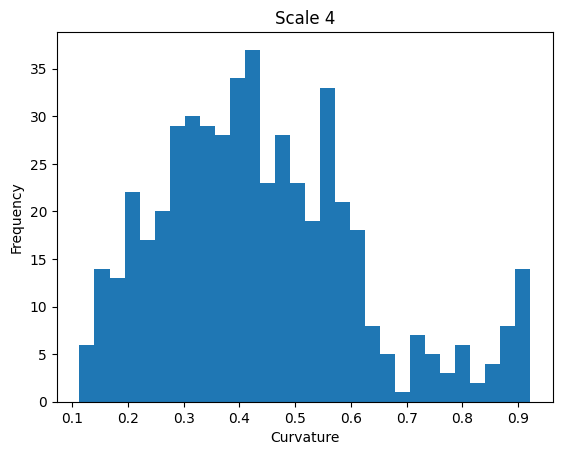

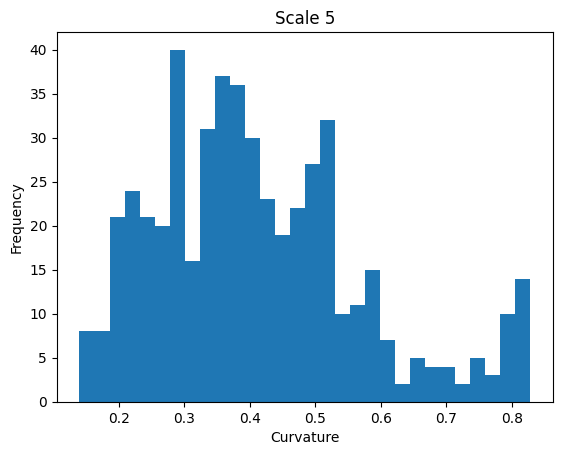

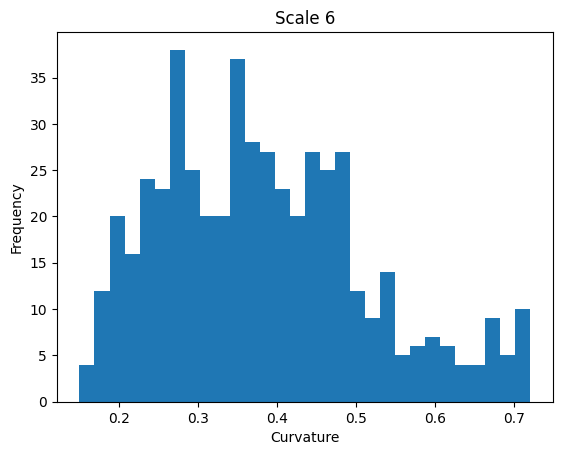

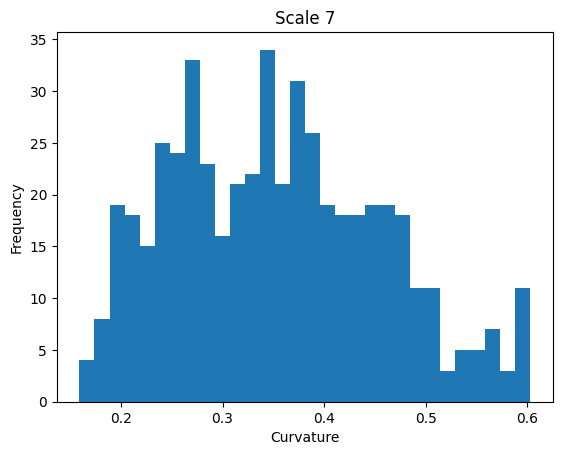

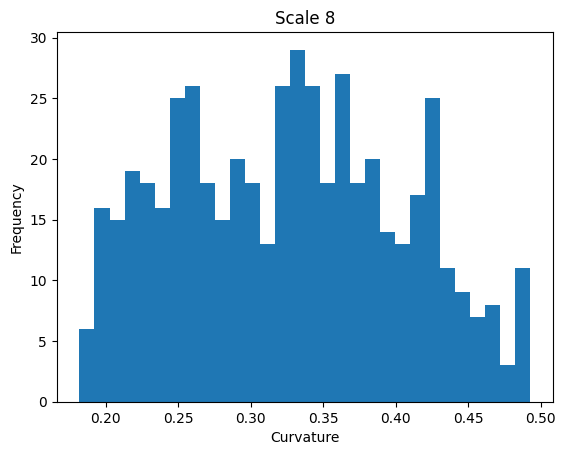

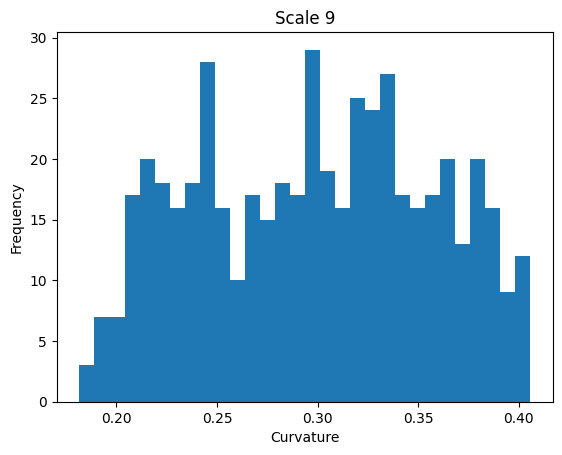

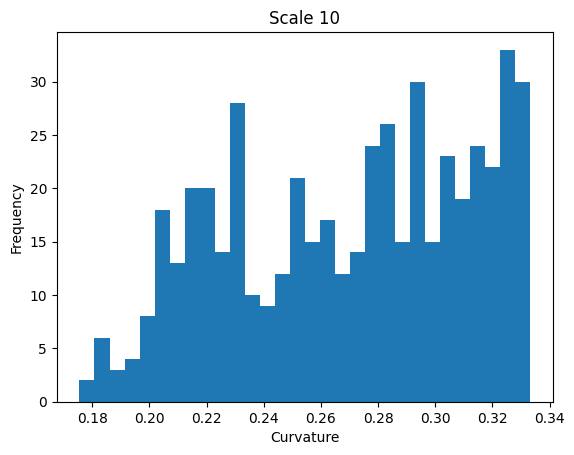

In [20]:
# plot histogram for each scale
for i in range(curvature_arr.shape[0]):
    plt.figure()
    plt.hist(curvature_arr[i], bins=30) # adjust the number of bins as needed
    plt.title('Scale {}'.format(i+1))
    plt.xlabel('Curvature')
    plt.ylabel('Frequency')

plt.show()

In [23]:
hist_values = []
for i in range(curvature_arr.shape[0]):
    plt.figure()
    counts, bin_edges = np.histogram(curvature_arr[i], bins=30) # adjust the number of bins as needed
    hist_values.append(counts)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
hist_values

[array([ 6,  5,  9, 10, 12, 11, 11,  7, 12, 14, 17, 14, 15, 15, 22, 28, 32,
        39, 37, 34, 22, 17, 19, 14, 24, 19, 16, 13,  2, 11], dtype=int64),
 array([ 7,  7, 15, 19, 17, 15, 17, 23, 28, 17, 19, 18, 18, 23, 28, 23, 30,
        22, 15, 16, 14, 13, 16, 10, 13, 12, 13,  8, 16, 15], dtype=int64),
 array([ 5, 12, 14, 15, 21, 31, 30, 17, 20, 23, 29, 30, 30, 24, 23, 27, 22,
        21, 11, 18, 19, 11,  7,  5,  3,  6,  3,  6,  6, 18], dtype=int64),
 array([ 6, 14, 13, 22, 17, 20, 29, 30, 29, 28, 34, 37, 23, 28, 23, 19, 33,
        21, 18,  8,  5,  1,  7,  5,  3,  6,  2,  4,  8, 14], dtype=int64),
 array([ 8,  8, 21, 24, 21, 20, 40, 16, 31, 37, 36, 30, 23, 19, 22, 27, 32,
        10, 11, 15,  7,  2,  5,  4,  4,  2,  5,  3, 10, 14], dtype=int64),
 array([ 4, 12, 20, 16, 24, 23, 38, 25, 20, 20, 37, 28, 27, 23, 20, 27, 25,
        27, 12,  9, 14,  5,  6,  7,  6,  4,  4,  9,  5, 10], dtype=int64),
 array([ 4,  8, 19, 18, 15, 25, 24, 33, 23, 16, 21, 22, 34, 21, 31, 26, 19,
        18, 18, 19

In [79]:
data = np.array([np.array(hist) for hist in hist_values])
X = data.flatten().tolist()
X

[3,
 1,
 4,
 1,
 3,
 2,
 3,
 6,
 6,
 4,
 6,
 13,
 24,
 41,
 43,
 37,
 31,
 17,
 11,
 4,
 4,
 4,
 0,
 1,
 2,
 2,
 1,
 4,
 2,
 2,
 3,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 10,
 11,
 13,
 24,
 41,
 39,
 32,
 21,
 11,
 6,
 4,
 5,
 0,
 5,
 1,
 4,
 5,
 0,
 1,
 4,
 5,
 4,
 3,
 6,
 6,
 7,
 8,
 9,
 7,
 7,
 11,
 15,
 16,
 28,
 36,
 26,
 27,
 5,
 9,
 9,
 4,
 4,
 3,
 4,
 3,
 2,
 4,
 4,
 6,
 1,
 5,
 7,
 5,
 7,
 8,
 11,
 11,
 8,
 9,
 10,
 11,
 14,
 29,
 26,
 27,
 25,
 4,
 10,
 10,
 8,
 4,
 5,
 4,
 1,
 4,
 2,
 3,
 6,
 6,
 1,
 4,
 9,
 6,
 9,
 6,
 14,
 9,
 15,
 13,
 11,
 15,
 19,
 26,
 27,
 15,
 9,
 9,
 10,
 12,
 9,
 6,
 4,
 2,
 4,
 3,
 4,
 5,
 4,
 3,
 6,
 5,
 2,
 7,
 8,
 11,
 14,
 11,
 11,
 16,
 12,
 14,
 16,
 17,
 29,
 13,
 7,
 5,
 7,
 9,
 9,
 12,
 11,
 5,
 4,
 3,
 5,
 3,
 4,
 4,
 5,
 5,
 5,
 6,
 8,
 9,
 9,
 14,
 7,
 14,
 17,
 14,
 14,
 16,
 15,
 13,
 14,
 12,
 4,
 4,
 8,
 7,
 9,
 10,
 13,
 10,
 3,
 5,
 7,
 6,
 6,
 5,
 3,
 3,
 7,
 7,
 11,
 10,
 9,
 10,
 13,
 15,
 15,
 11,
 15,
 11,
 8,
 13,
 10,
 11,
 6,
 6,


In [50]:
hist_values

[array([ 1,  2,  0,  4,  2,  4,  3,  1,  4,  4,  1,  5,  2,  3,  8,  7,  7,
        20, 46, 42, 54, 36, 29, 22, 10,  1,  3,  2,  0,  2], dtype=int64),
 array([ 2,  4,  5,  3,  7,  4,  4,  5,  5,  4,  4,  4,  3,  7,  6, 11, 19,
        40, 56, 50, 29, 23,  9,  5,  6,  2,  1,  3,  2,  2], dtype=int64),
 array([ 4,  6,  5,  4,  8, 10,  6,  3,  7,  5,  6,  6,  9,  7, 15, 26, 36,
        46, 38, 25, 16,  5,  8,  2,  8,  1,  4,  3,  4,  2], dtype=int64),
 array([ 4,  9,  6,  6, 10,  8,  6,  9,  7,  9,  8, 10, 14,  8, 16, 45, 48,
        36, 13,  5, 11,  6,  7,  4,  4,  5,  2,  2,  3,  4], dtype=int64),
 array([ 5,  9,  5,  8, 11,  9,  8, 10,  8, 13, 11, 16, 12, 15, 15, 30, 51,
        30,  7,  5,  6,  6,  5, 10,  7,  2,  4,  2,  1,  4], dtype=int64),
 array([ 7,  9,  4,  9,  9,  9,  9,  9, 15,  9, 18, 12, 13, 11,  6, 28, 37,
        34, 20,  6,  5,  7,  7,  9,  4,  4,  3,  4,  2,  6], dtype=int64),
 array([ 7,  8,  4,  9, 11,  9, 10, 11, 12, 12, 22, 11,  8, 13,  7, 21, 28,
        33, 23, 13

In [22]:
import numpy as np

# create a feature matrix X
X = np.hstack(hist_values).T

# create a label vector y
y = np.repeat(np.arange(len(hist_values)), [h.shape[0] for h in hist_values])

In [25]:
X

array([ 1,  2,  0,  4,  2,  4,  3,  1,  4,  4,  1,  5,  2,  3,  8,  7,  7,
       20, 46, 42, 54, 36, 29, 22, 10,  1,  3,  2,  0,  2,  2,  4,  5,  3,
        7,  4,  4,  5,  5,  4,  4,  4,  3,  7,  6, 11, 19, 40, 56, 50, 29,
       23,  9,  5,  6,  2,  1,  3,  2,  2,  4,  6,  5,  4,  8, 10,  6,  3,
        7,  5,  6,  6,  9,  7, 15, 26, 36, 46, 38, 25, 16,  5,  8,  2,  8,
        1,  4,  3,  4,  2,  4,  9,  6,  6, 10,  8,  6,  9,  7,  9,  8, 10,
       14,  8, 16, 45, 48, 36, 13,  5, 11,  6,  7,  4,  4,  5,  2,  2,  3,
        4,  5,  9,  5,  8, 11,  9,  8, 10,  8, 13, 11, 16, 12, 15, 15, 30,
       51, 30,  7,  5,  6,  6,  5, 10,  7,  2,  4,  2,  1,  4,  7,  9,  4,
        9,  9,  9,  9,  9, 15,  9, 18, 12, 13, 11,  6, 28, 37, 34, 20,  6,
        5,  7,  7,  9,  4,  4,  3,  4,  2,  6,  7,  8,  4,  9, 11,  9, 10,
       11, 12, 12, 22, 11,  8, 13,  7, 21, 28, 33, 23, 13,  9, 11, 11,  2,
        2,  3,  3,  4,  3,  5,  6,  8,  4,  6, 11,  8, 12,  7, 14, 13, 21,
        8, 14, 10, 13, 14

In [16]:
hist_values

[array([ 1,  2,  0,  4,  2,  4,  3,  1,  4,  4,  1,  5,  2,  3,  8,  7,  7,
        20, 46, 42, 54, 36, 29, 22, 10,  1,  3,  2,  0,  2], dtype=int64),
 array([ 2,  4,  5,  3,  7,  4,  4,  5,  5,  4,  4,  4,  3,  7,  6, 11, 19,
        40, 56, 50, 29, 23,  9,  5,  6,  2,  1,  3,  2,  2], dtype=int64),
 array([ 4,  6,  5,  4,  8, 10,  6,  3,  7,  5,  6,  6,  9,  7, 15, 26, 36,
        46, 38, 25, 16,  5,  8,  2,  8,  1,  4,  3,  4,  2], dtype=int64),
 array([ 4,  9,  6,  6, 10,  8,  6,  9,  7,  9,  8, 10, 14,  8, 16, 45, 48,
        36, 13,  5, 11,  6,  7,  4,  4,  5,  2,  2,  3,  4], dtype=int64),
 array([ 5,  9,  5,  8, 11,  9,  8, 10,  8, 13, 11, 16, 12, 15, 15, 30, 51,
        30,  7,  5,  6,  6,  5, 10,  7,  2,  4,  2,  1,  4], dtype=int64),
 array([ 7,  9,  4,  9,  9,  9,  9,  9, 15,  9, 18, 12, 13, 11,  6, 28, 37,
        34, 20,  6,  5,  7,  7,  9,  4,  4,  3,  4,  2,  6], dtype=int64),
 array([ 7,  8,  4,  9, 11,  9, 10, 11, 12, 12, 22, 11,  8, 13,  7, 21, 28,
        33, 23, 13

In [72]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Preprocess the data
data = np.array([np.array(hist) for hist in hist_values])
X = data.flatten().tolist()

X

[3,
 1,
 4,
 1,
 3,
 2,
 3,
 6,
 6,
 4,
 6,
 13,
 24,
 41,
 43,
 37,
 31,
 17,
 11,
 4,
 4,
 4,
 0,
 1,
 2,
 2,
 1,
 4,
 2,
 2,
 3,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 10,
 11,
 13,
 24,
 41,
 39,
 32,
 21,
 11,
 6,
 4,
 5,
 0,
 5,
 1,
 4,
 5,
 0,
 1,
 4,
 5,
 4,
 3,
 6,
 6,
 7,
 8,
 9,
 7,
 7,
 11,
 15,
 16,
 28,
 36,
 26,
 27,
 5,
 9,
 9,
 4,
 4,
 3,
 4,
 3,
 2,
 4,
 4,
 6,
 1,
 5,
 7,
 5,
 7,
 8,
 11,
 11,
 8,
 9,
 10,
 11,
 14,
 29,
 26,
 27,
 25,
 4,
 10,
 10,
 8,
 4,
 5,
 4,
 1,
 4,
 2,
 3,
 6,
 6,
 1,
 4,
 9,
 6,
 9,
 6,
 14,
 9,
 15,
 13,
 11,
 15,
 19,
 26,
 27,
 15,
 9,
 9,
 10,
 12,
 9,
 6,
 4,
 2,
 4,
 3,
 4,
 5,
 4,
 3,
 6,
 5,
 2,
 7,
 8,
 11,
 14,
 11,
 11,
 16,
 12,
 14,
 16,
 17,
 29,
 13,
 7,
 5,
 7,
 9,
 9,
 12,
 11,
 5,
 4,
 3,
 5,
 3,
 4,
 4,
 5,
 5,
 5,
 6,
 8,
 9,
 9,
 14,
 7,
 14,
 17,
 14,
 14,
 16,
 15,
 13,
 14,
 12,
 4,
 4,
 8,
 7,
 9,
 10,
 13,
 10,
 3,
 5,
 7,
 6,
 6,
 5,
 3,
 3,
 7,
 7,
 11,
 10,
 9,
 10,
 13,
 15,
 15,
 11,
 15,
 11,
 8,
 13,
 10,
 11,
 6,
 6,


In [20]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Step 3: Choose a value for K
k = 5

# Step 4: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Step 5: Evaluate the KNN model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

In [21]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# create sample data
data = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9])
]
labels = [0, 1, 0]

# flatten numpy arrays and concatenate them to form a feature vector
features = np.concatenate([arr.flatten() for arr in data]).reshape(-1, len(data[0]))

# normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# train a k-nearest neighbor model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(scaled_features, labels)

# predict labels for new data
new_data = [
    np.array([2, 3, 4]),
    np.array([5, 6, 7])
]
new_features = np.concatenate([arr.flatten() for arr in new_data]).reshape(-1, len(new_data[0]))
scaled_new_features = scaler.transform(new_features)
predicted_labels = knn.predict(scaled_new_features)
print(predicted_labels)

AttributeError: 'NoneType' object has no attribute 'split'